<a href="https://colab.research.google.com/github/AdolfoVillalobos/AdvancedProgrammingProjects/blob/master/Agrosuper_Presntacion_Ener2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminares


## Instalación Paquetes

In [0]:
%%capture
! pip install --upgrade pip
#!pip install dtw-python
! pip install tf-night
! pip install -U statsmodels
! pip install pymysql
! pip install plotly==4.4.1
! pip install "notebook>=5.3" "ipywidgets>=7.2"
! conda install -c plotly plotly-orca
! pip install jupyter_contrib_nbextensions
! pip install mip

## Importar Librerías

In [0]:

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import sqlite3
import pickle
import seaborn as sns
from datetime import datetime
import re
from joblib import dump, load
import pymysql
import copy

import scipy.integrate
import scipy.stats
import scipy.optimize

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#from dtw import dtw

import tensorflow as tf

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip


plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')



#import plotly.graph_objects as go
#import plotly.io as pio
#import plotly.express as px
#from plotly.subplots import make_subplots
#import plotly.figure_factory as ff

## Descargar archivos

In [0]:
#!wget -O data_linea.db https://raw.githubusercontent.com/AdolfoVillalobos/Smart-Bracelet/master/data/data_linea.db?token=AD66KJU54W7FYQX4HC6RVTK55ZO5E
#!wget -O data_filo.db https://raw.githubusercontent.com/AdolfoVillalobos/Smart-Bracelet/master/data/data_filo.db?token=AD66KJWU3LXUBQ3B5ZVFKIK55ZPGC
!wget -O best_model_f_beta1_tree.joblib https://github.com/AdolfoVillalobos/Smart-Bracelet/raw/master/src/feature_generation/model/best_model_f_beta1_tree.joblib
!wget -O best_parameters.json https://raw.githubusercontent.com/AdolfoVillalobos/Smart-Bracelet/master/src/feature_generation/results/best_parameters.json?token=AD66KJQCW7DMDU5ESCFM7Y26BX7MO

--2019-12-31 22:05:48--  https://github.com/AdolfoVillalobos/Smart-Bracelet/raw/master/src/feature_generation/model/best_model_f_beta1_tree.joblib
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2019-12-31 22:05:48 ERROR 404: Not Found.

--2019-12-31 22:05:51--  https://raw.githubusercontent.com/AdolfoVillalobos/Smart-Bracelet/master/src/feature_generation/results/best_parameters.json?token=AD66KJQCW7DMDU5ESCFM7Y26BX7MO
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 591 [text/plain]
Saving to: ‘best_parameters.json’

best_parameters.jso 100%[===================>]     591  --.-KB/s    in 0s      

2019-12-31 22:05:51 (211 MB/s) - ‘best_par

## Parámetros y Accesos

In [0]:

#DB_LINEA_PATH = '/content/data_linea.db'
#DB_FILO_PATH =  '/content/data_filo.db'
#TABLES_LINEA = ['linea_femur_14_10_19_experto_n1_processed_v',
#          'linea_femur_14_10_19_experto_n2_processed_v',
#          'linea_femur_17_10_19_inexperto_n1_processed_v',
#          'linea_femur_19_11_19_inexperto_n1_processed_v',
#          'linea_femur_19_11_19_inexperto_n2_processed_v',
#          'linea_femur_20_11_19_inexperto_n1_processed_v',
#          'linea_femur_20_11_19_inexperto_n2_processed_v',
#          'linea_femur_21_11_19_inexperto_n1_processed_v',
#          'linea_femur_21_11_19_experto_n1_processed_v']
          
#TABLES_FILO = ['femur_coxal_data_filo_2019_08_30']

MODEL_PATH = '/content/best_model_f_beta1_tree.joblib'
PARAMS_PATH = '/content/best_parameters.json'


##### PARAMS ####

GROUP_VARS = ['table_id', 'corte', 'velocidad_linea', 'experiencia']
FEAT_VARS = ['acc_RH', 'acc_LH', 'angv_RH', 'angv_LH']
OTHER_VARS = ['ang_x_RH', 'ang_y_RH', 'ang_z_RH', 'ang_x_LH', 'ang_y_LH', 'ang_z_LH']
MAX_VARS = ['date', 'count_cambio_cuchillo']+GROUP_VARS+FEAT_VARS+OTHER_VARS
DWT_VARS = FEAT_VARS+OTHER_VARS
OPT_CRITERIA = 'f_beta1'


#### Connection Params

db_credentials_linea = {
'host': 'smart-bracelet.cmq9hvb3wpmc.us-west-2.rds.amazonaws.com',
'port' : 3306,
'user':'admin',
'db_name': 'smart_bracelet_linea',
'password': 'smart-bracelet-uc'
}

db_credentials_filo = {
'host': 'smart-bracelet.cmq9hvb3wpmc.us-west-2.rds.amazonaws.com',
'port' : 3306,
'user':'admin',
'db_name': 'smart_bracelet_filo',
'password': 'smart-bracelet-uc'
}

# Data Loader desde SQL

## Clases DataLoaderLinea y DataLoaderFilo

In [0]:
class DataLoaderLinea(object):

    def __init__(self, db_credentials):

        self._host = db_credentials['host']
        self._port = db_credentials['port']
        self._user = db_credentials['user']
        self._pwd = db_credentials['password']
        self._dbname = db_credentials['db_name']

        self._data = None
        self._conn = None

    
    def load_data(self):

      self.get_connection()
      self._data = self.get_all_tables()
      self.do_preprocess()

    def get_connection(self):
        self._conn = pymysql.connect(host=self._host, port=self._port, user=self._user,
                                     db=self._dbname, password=self._pwd)
        
    def get_table_names(self):

      table_names_query = 'show tables';
      table_names = pd.read_sql(table_names_query, con=self._conn)
      table_names.columns = ['names']

      return table_names[table_names['names'].str.contains('processed')]

    def get_table_data(self, tb_name):

      table_query = 'SELECT * FROM {};'.format(tb_name)
      data = pd.read_sql(table_query, con=self._conn)
      data['table_id'] = tb_name
      return data

    def get_all_tables(self):

      table_names = self.get_table_names()
      concat_tables = pd.DataFrame([])

      for index, row in table_names.iterrows():
        data = self.get_table_data(row['names'])
        concat_tables = pd.concat([concat_tables, data])

      return concat_tables

    def do_preprocess(self):

        # Vector Features

        self._data["acc_RH"] = np.sqrt(self._data['acc_x_RH']**2+(self._data['acc_y_RH']**2)+(self._data['acc_z_RH']**2))
        self._data["angv_RH"] = np.sqrt(self._data['angv_x_RH']**2+(self._data['angv_y_RH']**2)+(self._data['angv_z_RH']**2))
        self._data["acc_LH"] = np.sqrt(self._data['acc_x_LH']**2+(self._data['acc_y_LH']**2)+(self._data['acc_z_LH']**2))
        self._data["angv_LH"] = np.sqrt(self._data['angv_x_LH']**2+(self._data['angv_y_LH']**2)+(self._data['angv_z_LH']**2))
        
        # Mantain Valuable Data
        self._data = self._data[self._data['reading'] == 1]
        self._data = self._data[self._data['is_process_on'] == 1]
        self._data = self._data[self._data['corte'] != 0]

        # Identification Features
        self._data['experiencia'] = self._data['table_id'].apply(lambda x: self.aux_get_experiencia(x))
        self._data['table_id'] = self._data['table_id'].apply(lambda x: self.aux_get_identifier(x))
        self._data['date'] = self._data['date'].apply(lambda x: datetime.strptime(x,'%Y/%m/%d %H:%M:%S.%f'))
        self._data.index = self._data['date']
  
    def aux_get_experiencia(self, x):
        if 'inexperto' in x:
          return 'inexperto'
        else:
          return 'experto'

    def aux_get_identifier(self, x):
      s = x[12:]
      return s[:-10]


class DataLoaderFilo():

    def __init__(self, db_credentials):

      self._host = db_credentials['host']
      self._port = db_credentials['port']
      self._user = db_credentials['user']
      self._pwd = db_credentials['password']
      self._dbname = db_credentials['db_name']

      self._conn = None
      self._data = None


    def load_data(self):

        self.get_connection()
        self._data = self.get_all_tables()
        self.do_preprocess()
    
    def get_connection(self):
          self._conn = pymysql.connect(host=self._host, port=self._port, user=self._user,
                                      db=self._dbname, password=self._pwd)
          
          
    def get_table_names(self):

        table_names_query = 'show tables';
        table_names = pd.read_sql(table_names_query, con=self._conn)
        table_names.columns = ['names']

        return table_names

    def get_table_data(self, tb_name):

        table_query = 'SELECT * FROM {};'.format(tb_name)
        data = pd.read_sql(table_query, con=self._conn)
        data['table_id'] = tb_name
        return data

    def get_all_tables(self):

      table_names = self.get_table_names()
      concat_tables = pd.DataFrame([])

      for index, row in table_names.iterrows():
        data = self.get_table_data(row['names'])
        concat_tables = pd.concat([concat_tables, data])

      return concat_tables
        
    def do_preprocess(self):
        self._data["acc_RH"] = np.sqrt(self._data['acc_x_RH']**2+(self._data['acc_y_RH']**2)+(self._data['acc_z_RH']**2))
        self._data["angv_RH"] = np.sqrt(self._data['angv_x_RH']**2+(self._data['angv_y_RH']**2)+(self._data['angv_z_RH']**2))
        self._data["acc_LH"] = np.sqrt(self._data['acc_x_LH']**2+(self._data['acc_y_LH']**2)+(self._data['acc_z_LH']**2))
        self._data["angv_LH"] = np.sqrt(self._data['angv_x_LH']**2+(self._data['angv_y_LH']**2)+(self._data['angv_z_LH']**2))

        self._data.index = self._data['date']
        self._data = self._data.sort_index()

    def get_benchmark(self):    
        self._data = self._data[self._data['demo']==2]
        self._data = self._data[self._data['etapa']=='Femur']
        corte_max = self._data['corte'].max()
        return self._data[self._data['corte']==corte_max]

In [0]:
data_loader_linea = DataLoaderLinea(db_credentials=db_credentials_linea)
data_loader_linea.load_data()

In [0]:
DATA_LINEA = data_loader_linea._data
print(len(DATA_LINEA))
DATA_LINEA.head()

98462


,level_0,date,acc_x_RH,acc_y_RH,acc_z_RH,acc_x_LH,acc_y_LH,acc_z_LH,angv_x_RH,angv_y_RH,angv_z_RH,angv_x_LH,angv_y_LH,angv_z_LH,ang_x_RH,ang_y_RH,ang_z_RH,ang_x_LH,ang_y_LH,ang_z_LH,reading,count_filo,count_cambio_cuchillo,count_warnings,is_process_on,corte,velocidad_linea,index,table_id,acc_RH,angv_RH,acc_LH,angv_LH,experiencia
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-10 09:50:45.776892,172,2019-12-10 09:50:45.776892,-0.913086,-0.297363,0.206055,-0.129395,-0.277832,0.857910,6.713867,-187.438965,-100.402832,56.152344,-32.775879,13.671875,-123.255615,70.647583,-115.988159,-30.866089,21.577148,-131.143799,1,0,0,0,1,1,B,172,10_12_19_experto_n2,0.982145,212.742027,0.911012,66.439929,experto
2019-12-10 09:50:46.018515,173,2019-12-10 09:50:46.018515,-0.615234,-0.635254,0.396484,-0.664551,-0.270508,0.622559,-17.028809,-109.313965,-94.909668,26.245117,60.302734,22.705078,-62.006836,46.625977,-49.367065,-30.080566,35.502319,-141.580811,1,0,0,0,1,1,B,173,10_12_19_experto_n2,0.969155,145.764770,0.949938,69.575474,experto
2019-12-10 09:50:46.603524,174,2019-12-10 09:50:46.603524,-0.239258,-0.694336,0.216797,-0.398438,0.129395,0.802734,-38.208008,78.674316,-7.507324,39.611816,-39.855957,30.029297,-78.294067,23.829346,-68.307495,7.349854,38.237915,-125.244141,1,0,0,0,1,1,B,174,10_12_19_experto_n2,0.765733,87.783027,0.905471,63.713044,experto
2019-12-10 09:50:46.843526,175,2019-12-10 09:50:46.843526,-0.672363,-0.666504,-0.772461,-0.448242,0.177246,0.806152,-77.880859,228.820801,56.579590,11.047363,-20.385742,6.774902,-111.950684,24.488525,-114.631348,17.089233,30.168457,-126.776733,1,0,0,0,1,1,B,175,10_12_19_experto_n2,1.221882,248.245115,0.939265,24.156200,experto
2019-12-10 09:50:47.083911,176,2019-12-10 09:50:47.083911,-0.661621,-0.534180,-0.460449,-0.417969,0.158203,0.771973,4.089355,-63.293457,14.587402,-5.004883,-8.544922,12.695312,-154.682007,20.451050,-168.090820,16.644287,27.339478,-127.831421,1,0,0,0,1,1,B,176,10_12_19_experto_n2,0.967008,65.081309,0.892002,16.100792,experto


In [0]:
data_loader_filo = DataLoaderFilo(db_credentials=db_credentials_filo)
data_loader_filo.load_data()

In [0]:
DATA_FILO = data_loader_filo._data
BENCHMARK_FILO = data_loader_filo.get_benchmark()
print(len(DATA_FILO))
DATA_FILO.head()

11110


,id,Unnamed: 0,date,acc_x_RH,acc_y_RH,acc_z_RH,angv_x_RH,angv_y_RH,angv_z_RH,ang_x_RH,ang_y_RH,ang_z_RH,acc_x_LH,acc_y_LH,acc_z_LH,angv_x_LH,angv_y_LH,angv_z_LH,ang_x_LH,ang_y_LH,ang_z_LH,state,etapa,corte,acc_RH,angv_RH,acc_LH,angv_LH,label,demo,table_id
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-08-30 13:55:52,2682,3,2019-08-30 13:55:52,-1.036133,-0.153320,-0.231934,-6.286621,-0.793457,-18.554688,-133.225708,73.476562,174.523315,1.291992,-0.407227,-0.383789,-31.005859,-172.912598,-44.006348,-142.981567,-55.980835,127.776489,1,Femur,0,1.072787,19.606826,1.407967,181.098560,E,1,femur_coxal_data_filo_2019_08_30
2019-08-30 13:55:52,2679,0,2019-08-30 13:55:52,-0.766602,-0.041992,-0.290039,3.967285,-68.176270,25.756836,164.245605,64.720459,107.957153,1.076660,-0.130371,0.196289,-20.263672,21.606445,-2.197266,-39.929810,-73.542480,6.849976,1,Femur,0,0.820709,72.987380,1.102145,29.703247,E,1,femur_coxal_data_filo_2019_08_30
2019-08-30 13:55:52,2680,1,2019-08-30 13:55:52,-0.922363,-0.092285,-0.155273,20.080566,-26.245117,-38.757324,173.122559,76.530762,113.252563,1.028320,-0.050293,0.379395,14.526367,36.071777,-15.197754,-28.811646,-72.229614,-8.052979,1,Femur,0,0.939883,50.932951,1.097229,41.751170,E,1,femur_coxal_data_filo_2019_08_30
2019-08-30 13:55:52,2681,2,2019-08-30 13:55:52,-0.931641,-0.067871,-0.104980,21.911621,-6.347656,-14.526367,-140.751343,75.855103,160.499268,0.804688,-0.838867,-0.253906,-0.122070,-164.489746,73.730469,-46.049194,-66.505737,24.669800,1,Femur,0,0.939990,27.044911,1.189827,180.258352,E,1,femur_coxal_data_filo_2019_08_30
2019-08-30 13:55:53,2684,5,2019-08-30 13:55:53,-0.941406,0.043457,-0.163086,-34.667969,42.968750,9.277344,-143.684692,77.354736,-164.739990,0.854004,0.282227,0.382812,67.077637,367.065430,27.465820,-22.307739,-56.854248,0.098877,1,Femur,0,0.956416,55.984379,0.977507,374.153458,E,1,femur_coxal_data_filo_2019_08_30


# Generador de Features

In [0]:
class FeatureGenerator():
    
    def __init__(self, data, grouping_variables, feature_variables, max_variables):

        self.data = data
        
        self.gp_vars = grouping_variables
        self.ft_vars = feature_variables
        self.mx_vars = max_variables
        self.th_dict = None
        self.norm = lambda x,y: abs(x-y)


    ## Main Functions:


    def get_groups(self):

        self.gf = self.data[self.mx_vars].groupby(self.gp_vars)
        self.gd = self.gf[self.ft_vars]

    
    def load_threshold_params(self, criteria, path):
        result = pd.read_csv(path, sep=';')
        r = result[result['criterio']==criteria][['acc_RH','acc_LH', 'angv_RH', 'angv_LH']]

        self.th_dict =  r.to_dict('records')[0]
        return self.th_dict

   ## Features: Statistics of the signal 
    def get_features_statistics(self):

        maximum = self.gd.max()
        minimum = self.gd.min()
        std = self.gd.std()
        median = self.gd.median()
        mean = self.gd.mean()
        

        r =  pd.concat([mean, maximum, minimum, std, median], axis=1)
        r = r.reset_index()
        r['id'] = range(len(r))
        
        r.__name__ = 'Statistics'
        return r
    # Features: Fourier Coefficients of the signal

    def get_features_fourier(self, num_coef):

        dct_coeffs = []
        for var in self.ft_vars:
            var_coefs = pd.DataFrame()

            for names, group in list(self.gf[var]):

                coef = fftpack.dct(group.values, 1, num_coef)
                dic = {var + str(i): coef[i] for i in range(num_coef)}
                var_coefs = var_coefs.append(dic, ignore_index=True)
            dct_coeffs.append(var_coefs)

        dct_coeffs = pd.concat(dct_coeffs, axis=1)

        return dct_coeffs

    # Features: Elapsed Time and Cumulative Time
    def get_features_time(self):
        r = self.gf['date'].apply(self.f_times)
        r2 = self.gf['date'].apply(self.f_times_inicio)
        r3 = self.gf['date'].apply(self.f_times_fin)
        r4 = self.gf['date'].apply(self.f_times_dt)
       
        r = r.reset_index()
        r2 = r2.reset_index() 
        r3 = r3.reset_index() 
        r4 = r4.reset_index()

        r2['inicio'] = r2['date']
        r2 = r2.drop(columns='date')
        r3['fin'] = r3['date']
        r3 = r3.drop(columns='date')
        r4['dt'] = r4['date']
        r4 = r4.drop(columns='date')
        cumulative_times = r.groupby(['table_id', 'corte']).sum().groupby(level=[0]).cumsum().reset_index()
        cumulative_times['cumulative'] = cumulative_times['date']
        cumulative_times = cumulative_times.drop(columns=['date'])

        r = r.merge(cumulative_times, left_on=['table_id', 'corte'], right_on=['table_id', 'corte'])
        r = r.merge(r2, left_on=['table_id', 'corte', 'experiencia', 'velocidad_linea'], right_on=['table_id', 'corte', 'experiencia', 'velocidad_linea'])
        r = r.merge(r3, left_on=['table_id', 'corte', 'experiencia', 'velocidad_linea'], right_on=['table_id', 'corte', 'experiencia', 'velocidad_linea'])
        r = r.merge(r4, left_on=['table_id', 'corte', 'experiencia', 'velocidad_linea'], right_on=['table_id', 'corte', 'experiencia', 'velocidad_linea'])
        r['id'] = range(len(r))
        r.__name__ = 'Elapsed times'
        return r
    
    def f_times(self, gr):
        return len(gr)/4

    def f_times_inicio(self, gr):
      return gr.index[0]
    
    def f_times_fin(self, gr):
      return gr.index[-1]

    def f_times_dt(self, gr):
      dt = (gr - gr.shift()).dt.total_seconds().mean()
      return dt

    # Features: Threshold Counting
    def f_threshold_counts(self, gr, th):
        n = len(gr)

        laser = np.repeat(th, n)

        x = range(n)
        idx = np.argwhere(np.diff(np.sign(gr - laser))).flatten()
        count = len(idx)
      
        return count
    
    def f_threshold_agg(self, gr):
        d = {key: self.f_threshold_counts(gr[key], value) for key,value in self.th_dict.items()}
        return pd.Series(d)
        
        
    def get_features_threshold(self):

        tc = self.gd.apply(self.f_threshold_agg)
        tc['id'] = range(len(tc))
        tc.reset_index(inplace=True)
        tc.__name__ = 'Threshold Counts'
        return pd.DataFrame(tc)
    
    
    # Features: Dinammic Time Warping with respect to Benchmark Signal
    def f_dwt(self, gr, s_bench, th):
        d = {key: dtw(gr[key].values, s_bench[key].values, dist=self.norm)[0] for key in th}
        return pd.Series(d)
    
    def get_features_dwt(self, s_bench, th):
        tc = self.gf.apply(lambda x: self.f_dwt(x, s_bench, th))
        tc['id'] = range(len(tc))
        tc.reset_index(inplace=True)
        return pd.DataFrame(tc)


    # Features: Area under curve
    def get_features_auc(self, variables):

      tc = self.gf.apply(lambda x: self.f_auc_aggregate(x, variables))
      tc['id'] = range(len(tc))
      tc.reset_index(inplace=True)
      return pd.DataFrame(tc)

    def f_auc_aggregate(self, gr, variables):
        d = {key: self.f_auc(gr[key]) for key in variables}
        return pd.Series(d)

    def f_auc(self, gr):
      return scipy.integrate.simps(gr)

    # Feature: Count angle threshold

    def f_threshold_angle(self, gr, th):
        n = len(gr)

        laser = np.repeat(th, n)

        x = range(n)
        idx = np.argwhere(np.diff(np.sign(gr - laser))).flatten()
        count = len(idx)
      
        return count
        
    def get_features_threshold_angle(self, th=170):

        tc = self.gf['ang_x_RH'].apply(lambda x: self.f_threshold_angle(x, th))
        tc = tc.reset_index()
        tc['id'] = range(len(tc))
        return pd.DataFrame(tc)

    # Feature: Cambio cuchillo:

    def get_features_cambio_cuchillo(self):
      tc = self.gf['count_cambio_cuchillo'].apply(lambda x:self.f_cambio_cuchillo(x))
      tc = tc.reset_index()
      tc['id'] = range(len(tc))
      return pd.DataFrame(tc)
        
    def f_cambio_cuchillo(self, gr):
      return max(gr)

# Hoja de Ruta Presentación: 

1. Análisis de medias y varianza.
  1. Media móvil a través del tiempo. Hubo una tendencia de reducción o de alza.
  2. Ver el efecto del cuchillo en productividad.
  3. Productividad del turno. (Extrapolar a todo el turno)
  4. ¿Qué sucedería si hubieramos cambiado cuchillo en cierto punto?. 
    i. Cada dos horas.
    ii. Cuando determina la media. Usar optimización. En ambos casos, cuanto aumenta la productividad. (cuantos cortes, y cuanto se demora cada corte).
  5. Regressión (función del cuchillo) en contraste con la productividad original. Fijar un umbral de cambio de cuchillo.
  6. Análisis de el costo del cuchillo.
2. Análisis de lesiones:
  1. Video de malos movimientos. 2 videos. bueno/malo.
  2. Mostrar contador de mal corte.
  3. Llevemos dos idicadores (velocidad angular e hiperangulacion)
  4. Llevar conteo global de todos los trabajadores.

# Filo Cuchillo: Análisis de Medias y Varianza:

## Carga de Features 

In [0]:
def tablas_cc(df):
    tables = []
    for name, group in df.groupby('table_id'):
      if 1 in group['count_cambio_cuchillo'].unique():
        tables.append(name)
    return tables
def merge_cc(dfs, cc):
    merge_vars = ['table_id', 'corte', 'id', 'experiencia', 'velocidad_linea']
    for i in range(len(dfs)):
      dfs[i] = dfs[i].merge(cc, left_on=merge_vars, right_on=merge_vars)
    return dfs

def generacion_features_cc(df, tables):
 
    df_cc = df[df['table_id'].isin(tables)].copy()

    features = {
        'elapsed_times': {'data': pd.DataFrame([]), 'variable': 'date'},
        'threshold_counts': {'data': pd.DataFrame([]), 'variable': 'acc_LH'},
        'statistics': {'data': pd.DataFrame([]), 'variable': ''},
        'area_under_curve': {'data': pd.DataFrame([]), 'variable': 'acc_LH'},
        'angle_count': {'data': pd.DataFrame([]), 'variable': 'ang_x_RH'},
    }

    for i, (names, group) in enumerate(df_cc.groupby(['table_id'])):
      fg = FeatureGenerator(group,
                            grouping_variables=GROUP_VARS,
                            feature_variables=FEAT_VARS,
                            max_variables=MAX_VARS)
      
      fg.load_threshold_params(OPT_CRITERIA, PARAMS_PATH)
      fg.get_groups()        


      elapsed_times = fg.get_features_time()
      threshold_counts = fg.get_features_threshold()
      statistics = fg.get_features_statistics()
      area_under_curve = fg.get_features_auc(OTHER_VARS)
      angle_count = fg.get_features_threshold_angle(th=150)
      cambio_cuchillo = fg.get_features_cambio_cuchillo()

      elapsed_times, threshold_counts, statistics, area_under_curve, angle_count = merge_cc([elapsed_times, threshold_counts, statistics, area_under_curve, angle_count], cambio_cuchillo)
      features['elapsed_times']['data'] = pd.concat([features['elapsed_times']['data'], elapsed_times])
      features['threshold_counts']['data'] = pd.concat([features['threshold_counts']['data'], threshold_counts])
      features['statistics']['data'] = pd.concat([features['statistics']['data'], statistics])
      features['area_under_curve']['data'] = pd.concat([features['area_under_curve']['data'], area_under_curve])
      features['angle_count']['data'] = pd.concat([features['angle_count']['data'], angle_count])

    return features

In [0]:
TABLAS_CC = tablas_cc(DATA_LINEA)
FEATURES_CC = generacion_features_cc(DATA_LINEA, TABLAS_CC) 

## Análisis de Media Móvil

In [0]:
def analisis_mm(features, selected_feature):

  variable = features[selected_feature]['variable']
  grouped_features = features[selected_feature]['data'].groupby('table_id')

  fig, axes = plt.subplots(1, len(TABLAS_CC), figsize=(25,10))
  for i, (tabla, data) in enumerate(grouped_features):


    group = data.copy()

    group.loc[group['count_cambio_cuchillo']==0, ].plot(x='id',  y=variable, ax=axes[i], title='Tabla: {}'.format(tabla), label='sin cc', style='bo-')
    group.loc[group['count_cambio_cuchillo']==1, ].plot(x='id',  y=variable, ax=axes[i], label='cc', style='ro-')

    MA = group[variable].copy().rolling(window=5).mean()
    STD = group[variable].rolling(window=5).std()
    
    MA.plot(label='Media Móvil', ax=axes[i], style='g^-')
    STD.plot(label='STD', ax=axes[i], style='y^-')
    #group.plot(x='id', y='MA_L', label=None, ax=axes[i], style='y^-')

  plt.suptitle('Tendencia CC: {}'.format(selected_feature))
  plt.legend()
  plt.show()




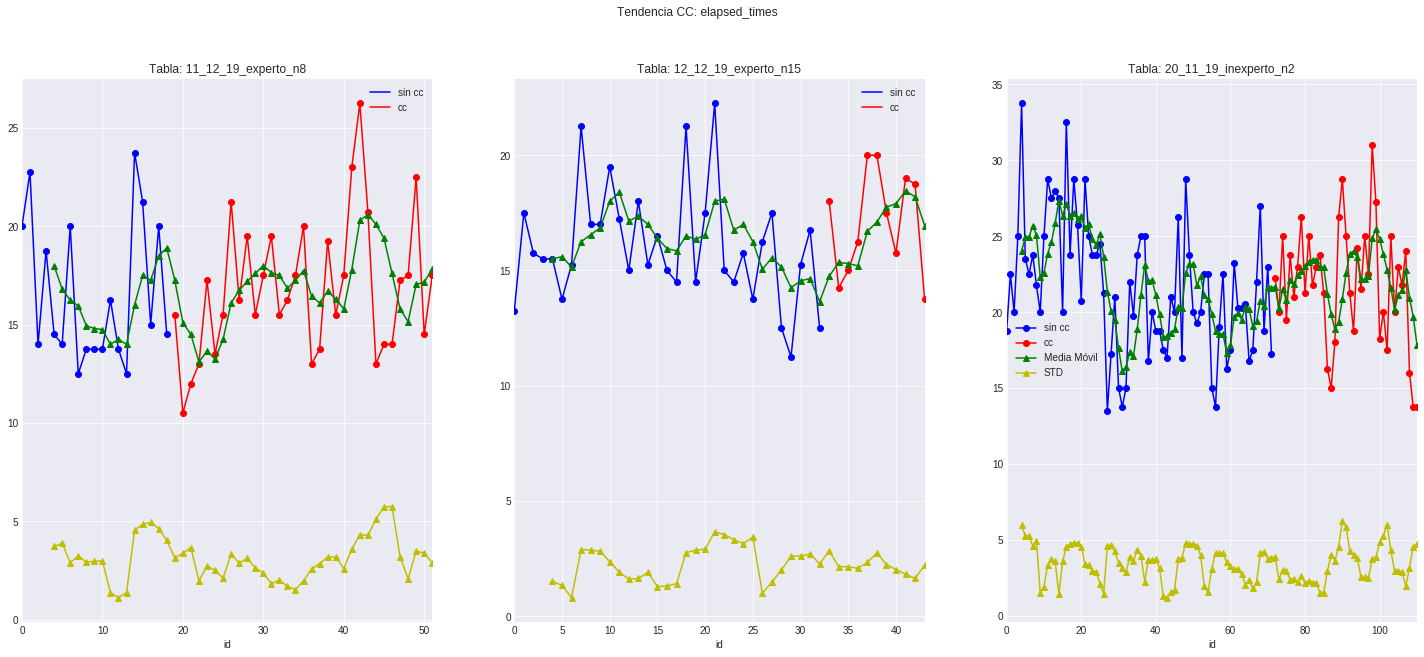

In [0]:
analisis_mm(features=FEATURES_CC, selected_feature='elapsed_times')

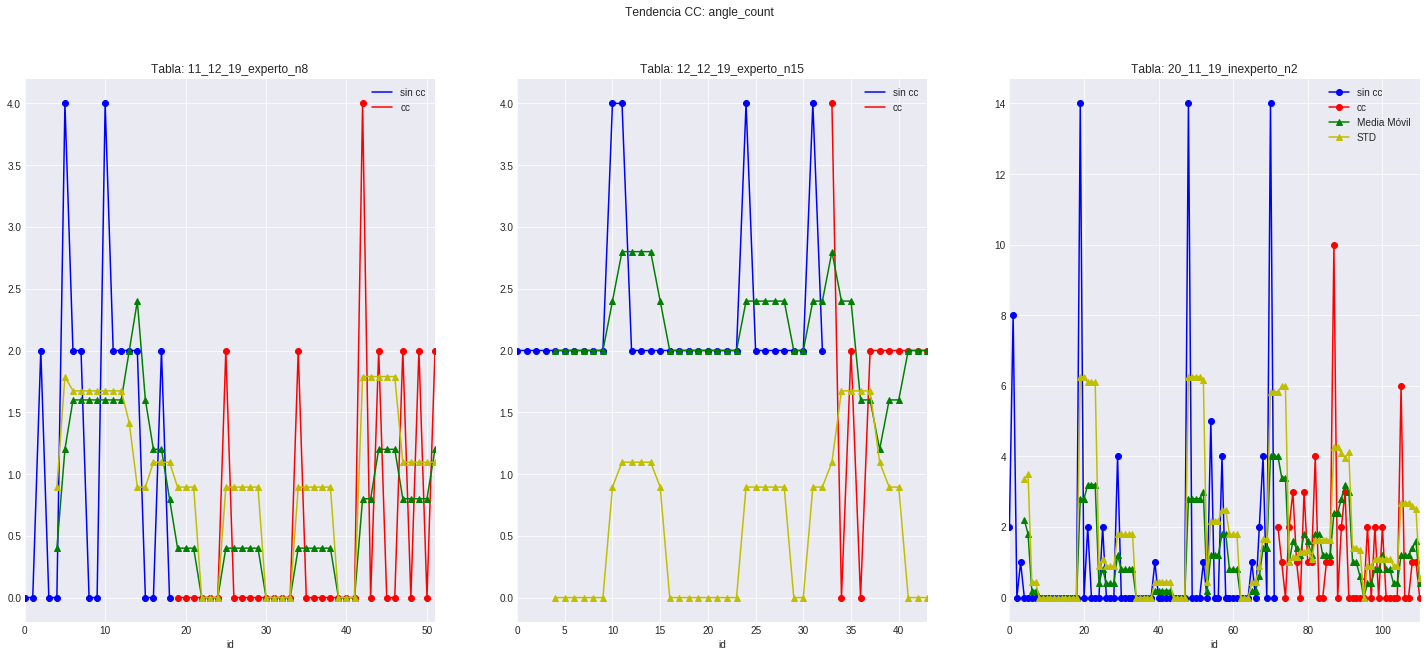

In [0]:
analisis_mm(features=FEATURES_CC, selected_feature='angle_count')

## Efecto en Productividad

In [0]:
def analisis_productividad(features, selected_feature):

  fig1, axes1 = plt.subplots(1, len(TABLAS_CC), figsize=(25,10))
  fig2, axes2 = plt.subplots(1, len(TABLAS_CC), figsize=(25,10))

  variable = features[selected_feature]['variable']
  grouped_features = features[selected_feature]['data'].groupby('table_id')

  for i, (tabla, data) in enumerate(grouped_features):

    group = data.copy()

    group.loc[group['count_cambio_cuchillo']==0, ].plot(x='id',  y=variable, ax=axes1[i], title='Tabla: {}, pglob={}'.format(tabla, (group[variable].sum())/len(group['corte'].unique())), label='sin cc', style='bo-')
    group.loc[group['count_cambio_cuchillo']==1, ].plot(x='id',  y=variable, ax=axes1[i], label='cc', style='ro-')
    res = optimal_resample_signal(group, variable)
    momento_optimo = res

    group = resample_signal(group, variable, momento_optimo)
    group.loc[group['count_cambio_cuchillo']==0, ].plot(x='id',  y='resampled', ax=axes2[i], title='Tabla: {}, pglob={}'.format(tabla, productividad_global(momento_optimo, group, 'resampled')), label='sin cc', style='bo-')
    group.loc[group['count_cambio_cuchillo']==1, ].plot(x='id',  y='resampled', ax=axes2[i], label='cc', style='ro-')

  plt.suptitle('Análsis Filo y {}'.format(selected_feature))
  plt.show()

def productividad_global(x, *args):

  group = args[0]
  variable = args[1]
  group = resample_signal(group, variable, x)
  result = (group[variable].sum())/len(group['corte'].unique())
  return result

def resample_signal(group, variable, candidate):
  if type(candidate)== int:
    momento_optimo = candidate
  else:
    momento_optimo = int(candidate[0])

  resample_value = group.loc[group['count_cambio_cuchillo']==1, variable].median()
  momento_cc = group.loc[group['count_cambio_cuchillo']==1, variable].index[0]

  group['resampled'] = group[variable]

  if momento_optimo <= momento_cc:
    group.loc[momento_optimo: momento_cc, 'resampled'] = resample_value
  else:
    #group.loc[momento_optimo:, 'resampled'] = resample_value
    pass
  return group

def optimal_resample_signal(group, variable):

  res = min(range(0,len(group)-1), key=lambda x: productividad_global(x,group,variable))

  return res


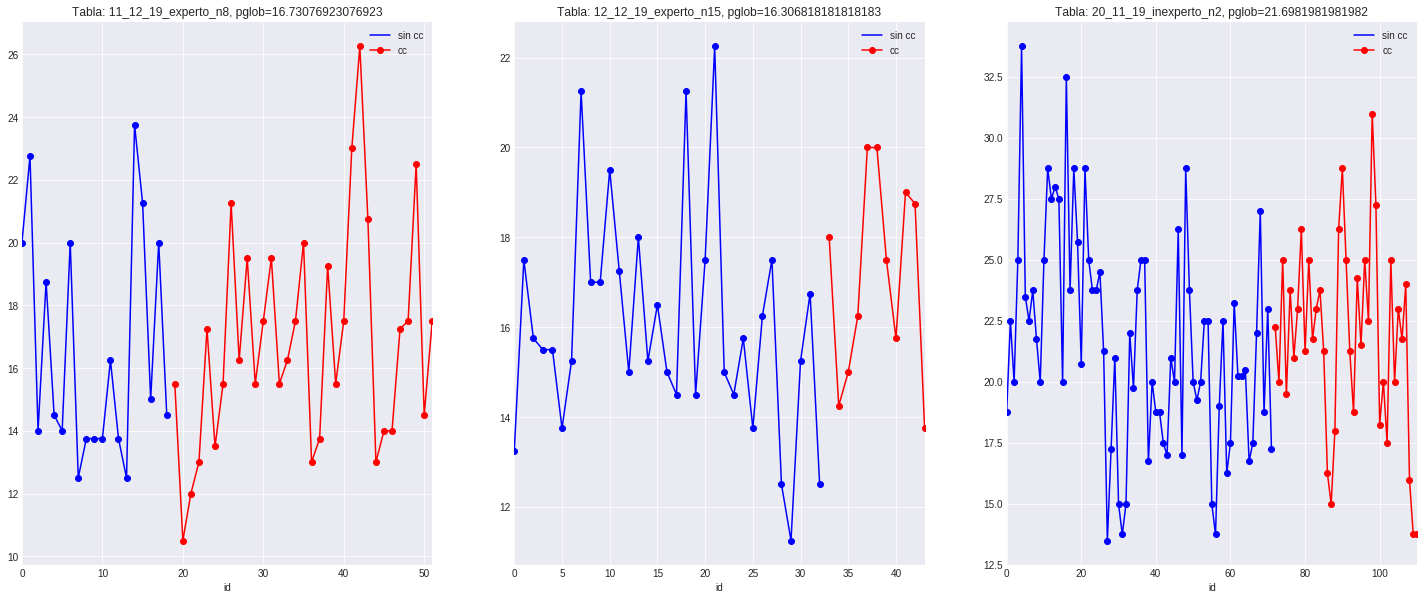

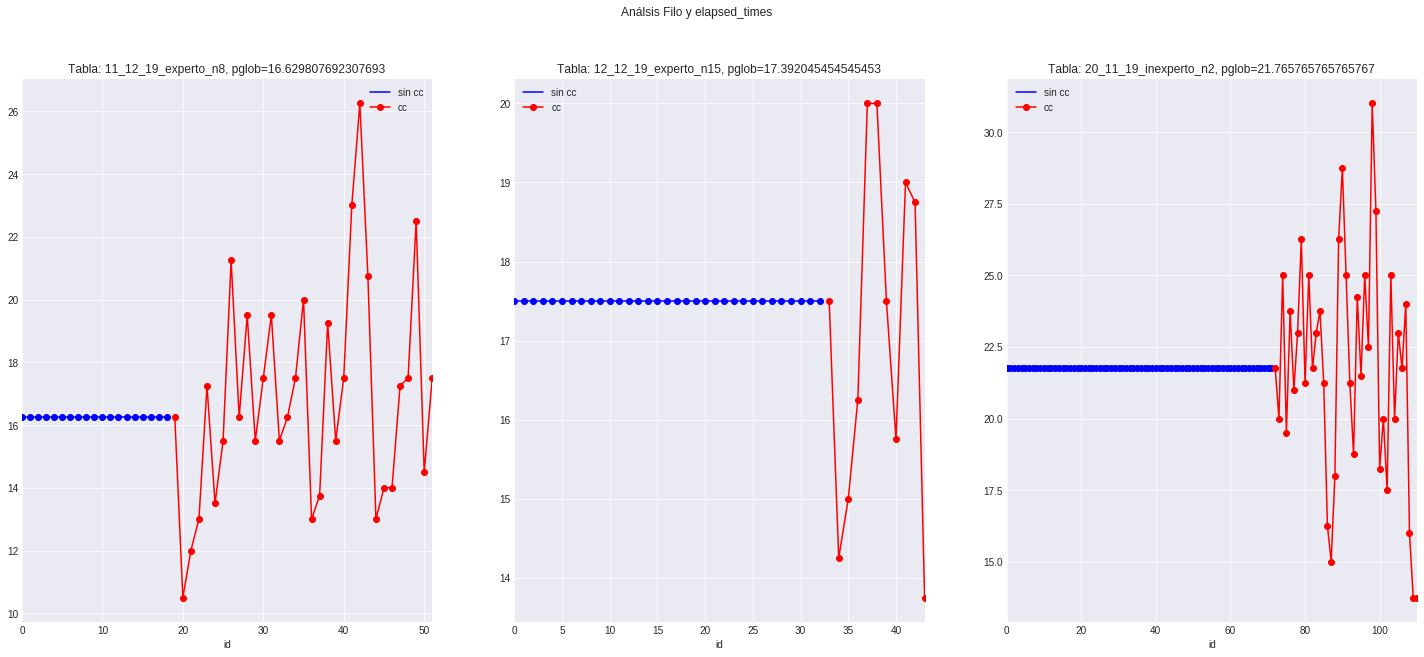

In [0]:
analisis_productividad(features=FEATURES_CC, selected_feature='elapsed_times')

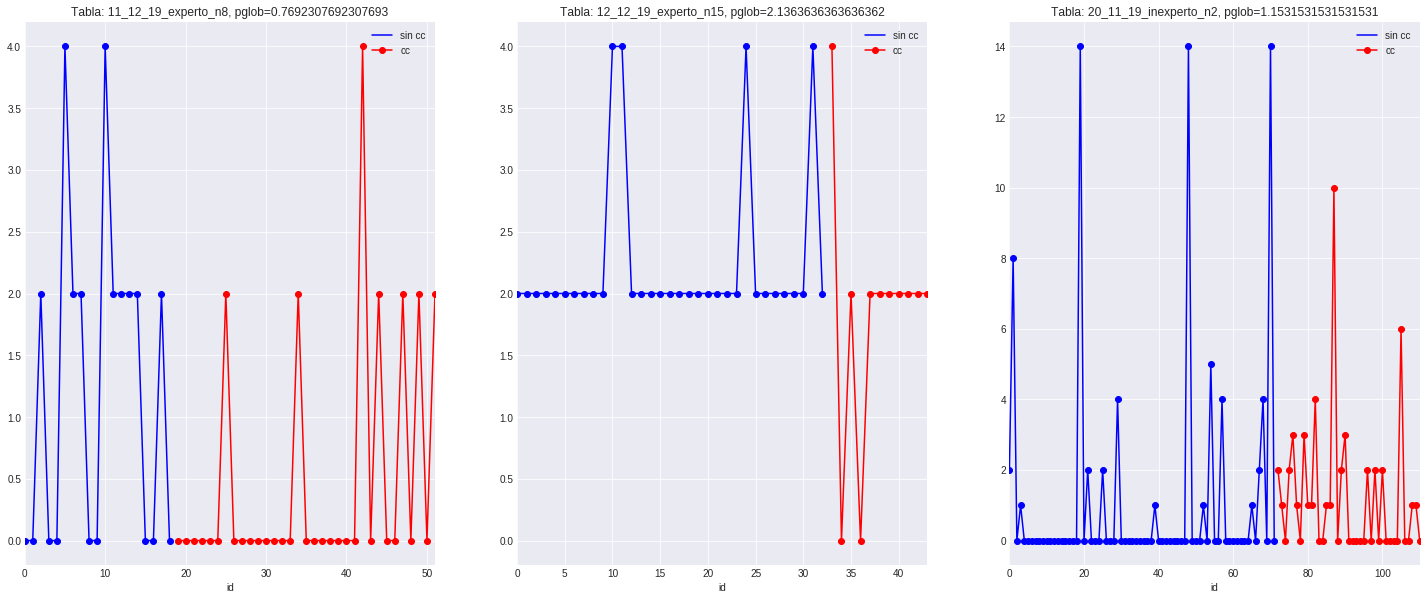

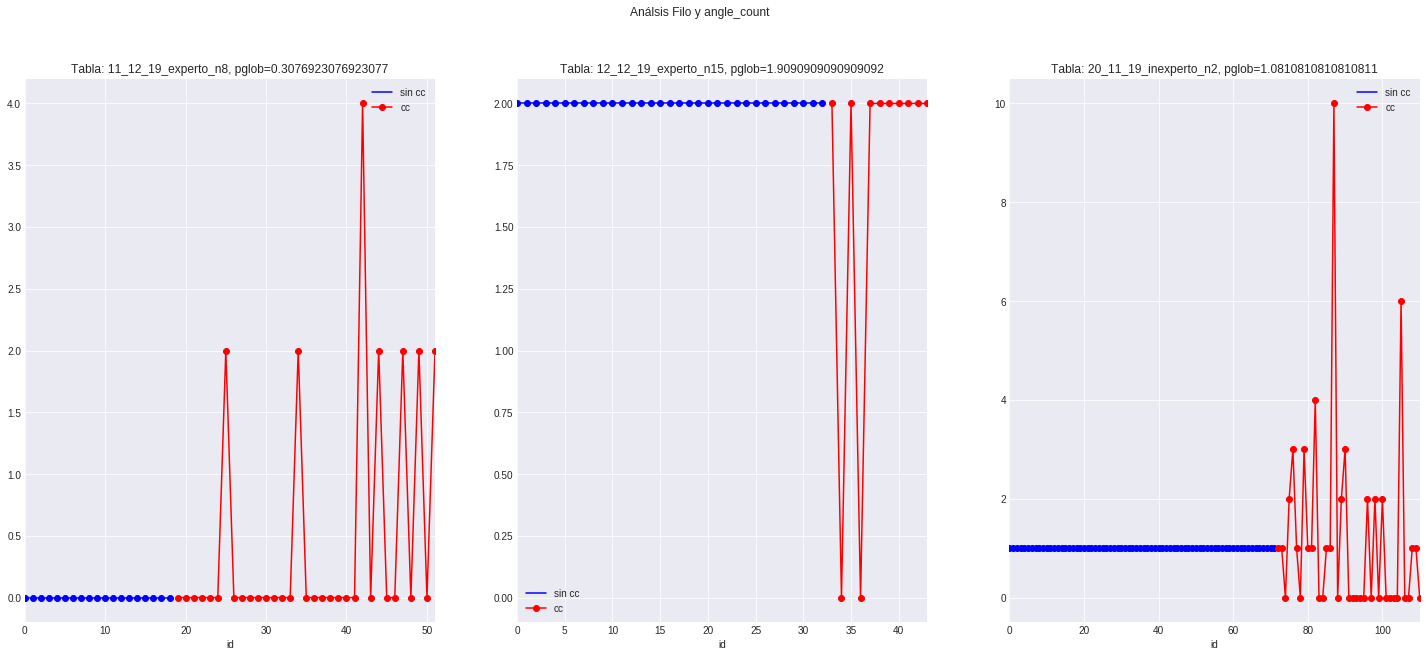

In [0]:
analisis_productividad(features=FEATURES_CC, selected_feature='angle_count')

## Productividad del Turno

In [0]:
def productividad_turno(features, selected_feature, num_hrs):
  variable = features[selected_feature]['variable']
  grouped_features = features[selected_feature]['data'].groupby('table_id')

  for i, (tabla, data) in enumerate(grouped_features):

    group = data.copy()
    print("Tabla: {}".format(tabla))
    print("############")

    extended_prod(group, variable, num_hrs)

    res = optimal_resample_signal(group, variable)
    momento_optimo = res
    group = resample_signal(group, variable, momento_optimo)

    extended_prod(group,'resampled', num_hrs)


def extended_prod(group, variable, num_hrs):
  segundos = group[variable]/2.9
  print('Variable: {}'.format(variable))
  prod_conocida = segundos.sum()/len(group['corte'])
  print('Tasa : {} seg/corte'.format(prod_conocida))
  print('Cortes hora: {} cortes/hora'.format(3600/prod_conocida))
  print('Cortes turno: {} cortes/hora'.format(num_hrs* 3600/prod_conocida))
  print("---------------")


In [0]:
productividad_turno(FEATURES_CC, 'elapsed_times', 6)

Tabla: 11_12_19_experto_n8
############
Variable: date
Tasa : 5.76923076923077 seg/corte
Cortes hora: 623.9999999999999 cortes/hora
Cortes turno: 3743.9999999999995 cortes/hora
---------------
Variable: resampled
Tasa : 5.734416445623343 seg/corte
Cortes hora: 627.7883781439722 cortes/hora
Cortes turno: 3766.730268863833 cortes/hora
---------------
Tabla: 12_12_19_experto_n15
############
Variable: date
Tasa : 5.6230407523510975 seg/corte
Cortes hora: 640.2229965156794 cortes/hora
Cortes turno: 3841.3379790940767 cortes/hora
---------------
Variable: resampled
Tasa : 5.997257053291537 seg/corte
Cortes hora: 600.2744201241424 cortes/hora
Cortes turno: 3601.646520744854 cortes/hora
---------------
Tabla: 20_11_19_inexperto_n2
############
Variable: date
Tasa : 7.482137309723517 seg/corte
Cortes hora: 481.14594145733855 cortes/hora
Cortes turno: 2886.8756487440314 cortes/hora
---------------
Variable: resampled
Tasa : 7.505436470953713 seg/corte
Cortes hora: 479.65231788079467 cortes/hora

In [0]:
productividad_turno(FEATURES_CC, 'angle_count', 6)

Tabla: 11_12_19_experto_n8
############
Variable: ang_x_RH
Tasa : 0.26525198938992045 seg/corte
Cortes hora: 13571.999999999998 cortes/hora
Cortes turno: 81431.99999999999 cortes/hora
---------------
Variable: resampled
Tasa : 0.10610079575596817 seg/corte
Cortes hora: 33930.0 cortes/hora
Cortes turno: 203580.0 cortes/hora
---------------
Tabla: 12_12_19_experto_n15
############
Variable: ang_x_RH
Tasa : 0.7366771159874609 seg/corte
Cortes hora: 4886.808510638298 cortes/hora
Cortes turno: 29320.851063829785 cortes/hora
---------------
Variable: resampled
Tasa : 0.6583072100313481 seg/corte
Cortes hora: 5468.5714285714275 cortes/hora
Cortes turno: 32811.428571428565 cortes/hora
---------------
Tabla: 20_11_19_inexperto_n2
############
Variable: ang_x_RH
Tasa : 0.39763901832867354 seg/corte
Cortes hora: 9053.437499999998 cortes/hora
Cortes turno: 54320.62499999999 cortes/hora
---------------
Variable: resampled
Tasa : 0.3727865796831315 seg/corte
Cortes hora: 9656.999999999998 cortes/hor

## Productividad Según Política

In [0]:
def extended_features(features, selected_feature, hrs):
  variable = features[selected_feature]['variable']
  grouped_features = features[selected_feature]['data'].groupby('table_id')
  e_df = pd.DataFrame([])

  for i, (tabla, data) in enumerate(grouped_features):

    group = data.copy() # Tomo un grupo 
    e_group = extend_group(group, hrs) # Lo extiendo hasta alcanzar el numero de horas requerido
    e_df = pd.concat([e_df, e_group]) # Añadir a tasbla general

  return e_df

def extend_group(group, hrs):

  thrash = group.copy()
  total_hours, time_delta = get_total_hours(group)
  size = int(hrs/total_hours)

  eg = pd.DataFrame([])
  for i in range(size):
    thrash['inicio'] = thrash['inicio']+time_delta
    thrash['fin'] = thrash['fin']+time_delta
    eg = pd.concat([eg, thrash], axis=0)
  eg.index = range(len(eg))
  return eg

def get_total_hours(group):
  delta = group.loc[len(group)-1, 'fin']-group.loc[0, 'inicio']
  return delta.total_seconds()/3600, delta

In [0]:
def analisis_policy(features, selected_feature, num_hrs, change_interval):
  
  e_features = extended_features(features, selected_feature, num_hrs)
  variable = features[selected_feature]['variable']
  grouped_extended_features = e_features.groupby('table_id')

  fig, axes = plt.subplots(len(TABLAS_CC), 2, figsize=(25,10))

  for i, (table, data) in enumerate(grouped_extended_features):

    group = data.copy()
    costo_cambio_extended = calcular_costo_cuchillo(group, 'count_cambio_cuchillo')
    prod_extended = group[variable].sum()/len(group['corte'])
    group.loc[group['count_cambio_cuchillo']==0,].plot(y=variable, ax=axes[i, 0], title='Table {}, Prod={} corte/hora, Cost={} cambios'.format(table, prod_extended, costo_cambio_extended), label='sin cc')
    group.loc[group['count_cambio_cuchillo']==1,].plot(y=variable, ax=axes[i, 0], label='cc')

    #axes[0, 0].set_title('extended')
    #axes[0, 1].set_title('politica {}hrs'.format(change_interval))

    group, costo_cambio_original = politica_original(group, variable, 6, change_interval)
    prod_politica_original = group['resampled'].sum()/len(group['corte'])
    group.loc[group['politica_original']==0,].plot(y='resampled', ax=axes[i, 1], title='Table {}, Prod={} corte/hora, Cost={} cambios'.format(table, prod_politica_original, costo_cambio_original), label='sin cc')
    group.loc[group['politica_original']==1,].plot(y='resampled', ax=axes[i, 1], label='cc')


def politica_original(group, variable,  num_hours, change_interval):
  resample_value = group.loc[group['count_cambio_cuchillo']==1, variable].mean()

  group['resampled'] = group[variable]
  group.loc[:, 'politica_original'] = 0
  group['lags'] = group['inicio']-group['inicio'].iloc[0]
  group['lags']= group['lags'].dt.components['hours']
  for i in range(change_interval, num_hours+1, change_interval):
    selected = group.loc[group['lags']>=i, 'lags']
    selected = selected.loc[selected<=i]
    if len(selected)>0:
      group.loc[group['lags'].isin(list(selected)), 'politica_original'] = 1
  group.loc[group['politica_original']==1, 'resampled'] = resample_value

  costo_cambio = calcular_costo_cuchillo(group, 'politica_original')

  return group, costo_cambio

def calcular_costo_cuchillo(group, variable):

  cantidad_cambios = group[variable]-group[variable].shift()
  cantidad_cambios = cantidad_cambios[cantidad_cambios>0]

  return sum(cantidad_cambios)

def politica_optima(group, variable, num_hours, change_interval):

    resample_value = group.loc[group['count_cambio_cuchillo']==1, variable].mean()

    group['resampled'] = group[variable]
    group.loc[:, 'politica_optima'] = 0
    group['lags'] = group['inicio']-group['inicio'].iloc[0]
    group['lags'] = group['lags'].dt.components['hours']
    for i in range(change_interval, num_hours+1, change_interval):
      selected = group.loc[group['lags']>=i, 'lags']
      selected = selected.loc[selected<=i]
      if len(selected)>0:
        group.loc[group['lags'].isin(list(selected)), 'politica_original'] = 1
    group.loc[group['politica_original']==1, 'resampled'] = resample_value

    return group, 


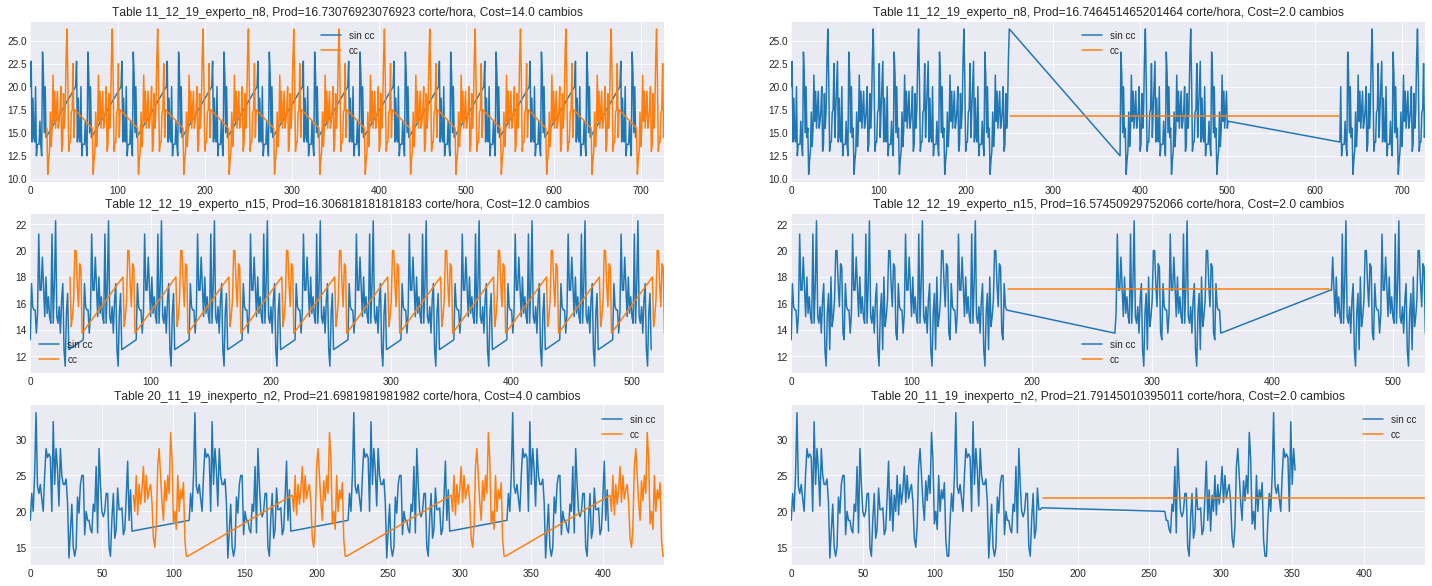

In [170]:
analisis_policy(FEATURES_CC, 'elapsed_times', 6, 2)

## Regresión

## Análisis del costo de cuchillo

# Análisis de Lesiones

## Videos de Movimientos

## Contador según variables